In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
!pip install pyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 8.6 MB/s eta 0:00:00


In [2]:
!pip install tensorflow==2.15.0     #2.15.0 te kaaj kre    
# !pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.0 MB/s eta 0:00:0000:01
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [3]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Lambda, SeparableConv2D, GlobalAvgPool2D, Input, Average, ReLU, Dropout, DepthwiseConv2D, Dense, GlobalAvgPool2D, GlobalAveragePooling2D,Conv2D, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, AvgPool2D, Concatenate, MaxPool2D
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU


from keras.preprocessing import image

from glob import glob

from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
from keras.models import Sequential,Model
import pandas as pd
# from keras.applications.resnet import ResNet50

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import time
import datetime
import os
import cv2
import io

from datetime import datetime
from keras.callbacks import ModelCheckpoint

# import imutils
import matplotlib.pyplot as plt
from os import listdir

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

2024-03-12 05:30:16.736460: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 05:30:16.736585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 05:30:16.886213: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Set the path to the dataset
# dataset_path = "C:/Users/USER/ML/Latest/def_data"
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"

# Define the training and testing directories
train_dir = os.path.join(dataset_path, "/kaggle/input/brain-tumor-mri-dataset/Training")
test_dir = os.path.join(dataset_path, "/kaggle/input/brain-tumor-mri-dataset/Testing")

# Define the categories
categories = ["glioma", "meningioma", "notumor", "pituitary"]

1321
1339
1595
1457


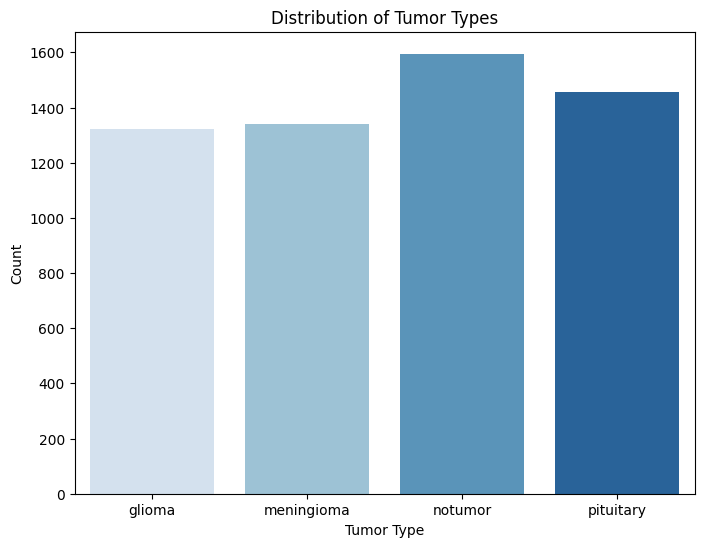

In [5]:
# Load and preprocess the dataset
train_data = []
for category in categories:
    folder_path = os.path.join(train_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    print(count)
    train_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

train_df = pd.concat(train_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=train_df, x="Category", y="Count", palette = "Blues")#######, legend=False
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

300
306
405
300


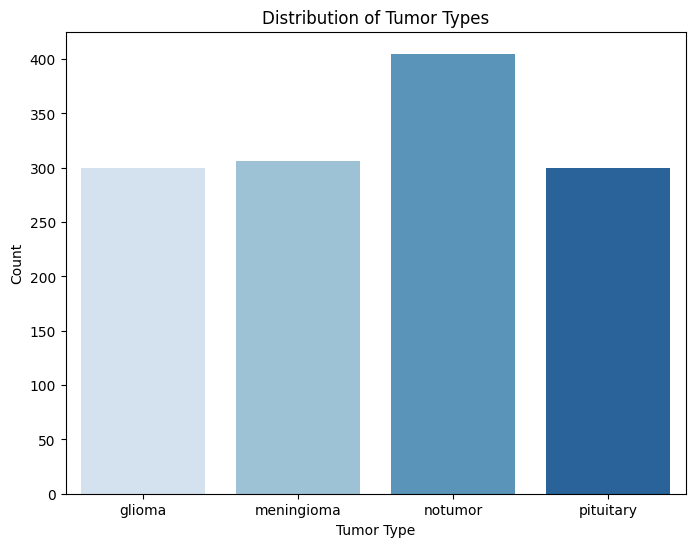

In [6]:
# Load and preprocess the dataset
test_data = []
for category in categories:
    folder_path = os.path.join(test_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    print(count)
    test_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

test_df = pd.concat(test_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=test_df, x="Category", y="Count", palette = "Blues")
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

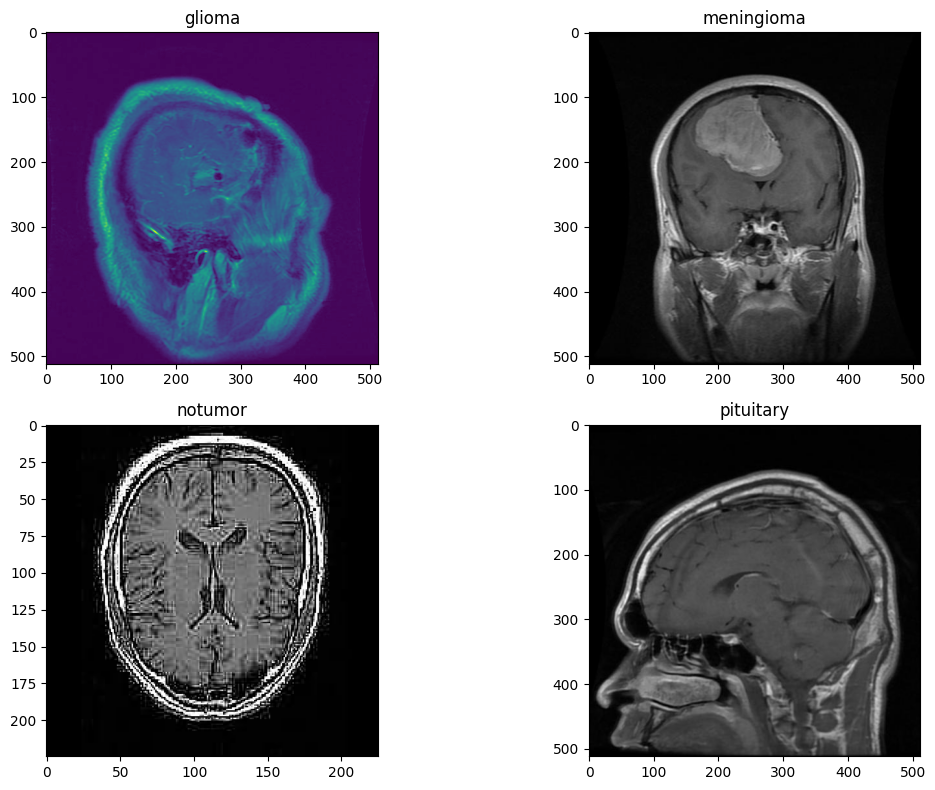

In [7]:
# Visualize sample images for each tumor type
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("on")
plt.tight_layout()
plt.show()

In [5]:
# Set the image size
image_size = (150, 150)

# Set the batch size for training
batch_size = 32

# Set the number of epochs for training
epochs = 50

In [6]:
# Data augmentation and preprocessing
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [10]:
def xception(input_shape, n_classes):

  def conv_bn(x, f, k, s=1, p='same'):
    x = Conv2D(f, k, strides=s, padding=p, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


  def sep_bn(x, f, k, s=1, p='same'):
    x = SeparableConv2D(f, k, strides=s, padding=p, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


  def entry_flow(x):
    x = conv_bn(x, 32, 3, 2)
    x = ReLU()(x)
    x = conv_bn(x, 64, 3)
    tensor = ReLU()(x)

    x = sep_bn(tensor, 128, 3)
    x = ReLU()(x)
    x = sep_bn(x, 128, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, 128, 1, 2)

    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, 256, 3)
    x = ReLU()(x)
    x = sep_bn(x, 256, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, 256, 1, 2)

    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, 728, 3)
    x = ReLU()(x)
    x = sep_bn(x, 728, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, 728, 1, 2)
    x = Add()([tensor, x])

    return x


  def middle_flow(tensor):
    for _ in range(8):
      x = ReLU()(tensor)
      x = sep_bn(x, 728, 3)
      x = ReLU()(x)
      x = sep_bn(x, 728, 3)
      x = ReLU()(x)
      x = sep_bn(x, 728, 3)

      tensor = Add()([tensor, x])

    return tensor


  def exit_flow(tensor):
    x = ReLU()(tensor)
    x = sep_bn(x, 728, 3)
    x = ReLU()(x)
    x = sep_bn(x, 1024, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, 1024, 1, 2)

    x = Add()([tensor, x])
    x = sep_bn(x, 1536, 3)
    x = ReLU()(x)
    x = sep_bn(x, 2048, 3)
    x = ReLU()(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(n_classes, activation='softmax')(x)

    return x


  input = Input(input_shape)

  x = entry_flow(input)
  x = middle_flow(x)
  output = exit_flow(x)

  model = Model(input, output)

  return model

In [11]:
IMG_SHAPE = (150, 150, 3)

In [12]:
xception_model = xception(IMG_SHAPE, 4)

In [13]:
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 75, 75, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 75, 75, 32)           0         ['batch_normalization[0][0

In [14]:
from keras.applications.inception_v3 import InceptionV3
InceptionV3 = InceptionV3(input_shape=(150, 150, 3),
            weights='imagenet',
            include_top=False)

87910968/87910968 [==============================] - 1s 0us/step


In [15]:
for layer in InceptionV3.layers:
    layer.trainable = False

In [16]:
folders = glob('/kaggle/input/brain-tumor-mri-dataset/Training/*')
print(len(folders))

4


In [17]:
x = InceptionV3.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)
InceptionV3_model = Model(inputs=InceptionV3.input, outputs=prediction)

In [18]:
InceptionV3_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_40 (Ba  (None, 74, 74, 32)           96        ['conv2d_6[0][0]']            
 tchNormalization)                                                                                
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization_40

In [11]:
# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001, verbose=1)

In [20]:
# Define callbacks
Xception_checkpoint = ModelCheckpoint(filepath='Xception_checkpoint.h5', 
                                       monitor='val_accuracy', 
                                       verbose=1, 
                                       save_best_only=True, 
                                       mode='max')

Xception_callbacks = [Xception_checkpoint, reduce_lr]

start = datetime.now()

In [21]:
xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# Define callbacks
InceptionV3_checkpoint = ModelCheckpoint(filepath='InceptionV3_checkpoint.h5', 
                                       monitor='val_accuracy', 
                                       verbose=1, 
                                       save_best_only=True, 
                                       mode='max')

InceptionV3_callbacks = [InceptionV3_checkpoint, reduce_lr]

start = datetime.now()

In [23]:
# adam = keras.optimizers.Adam(learning_rate=0.001)
InceptionV3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Train the model
history_xception_model = xception_model.fit(
    train_set,
    steps_per_epoch=train_set.samples // batch_size,
    epochs=epochs,
    validation_data=test_set,
    validation_steps=test_set.samples // batch_size,
    callbacks=Xception_callbacks
)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50


I0000 00:00:1710189803.614175     170 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


178/178 [==============================] - ETA: 0s - loss: 0.8506 - accuracy: 0.6514
Epoch 1: val_accuracy improved from -inf to 0.21016, saving model to Xception_checkpoint.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


178/178 [==============================] - 118s 474ms/step - loss: 0.8506 - accuracy: 0.6514 - val_loss: 1.3845 - val_accuracy: 0.2102 - lr: 0.0010
Epoch 2/50
178/178 [==============================] - ETA: 0s - loss: 0.6097 - accuracy: 0.7757
Epoch 2: val_accuracy improved from 0.21016 to 0.24219, saving model to Xception_checkpoint.h5
178/178 [==============================] - 53s 294ms/step - loss: 0.6097 - accuracy: 0.7757 - val_loss: 1.9940 - val_accuracy: 0.2422 - lr: 0.0010
Epoch 3/50
178/178 [==============================] - ETA: 0s - loss: 0.4826 - accuracy: 0.8257
Epoch 3: val_accuracy improved from 0.24219 to 0.60625, saving model to Xception_checkpoint.h5
178/178 [==============================] - 52s 291ms/step - loss: 0.4826 - accuracy: 0.8257 - val_loss: 1.2054 - val_accuracy: 0.6062 - lr: 0.0010
Epoch 4/50
178/178 [==============================] - ETA: 0s - loss: 0.3343 - accuracy: 0.8769
Epoch 4: val_accuracy improved from 0.60625 to 0.75859, saving model to Xception

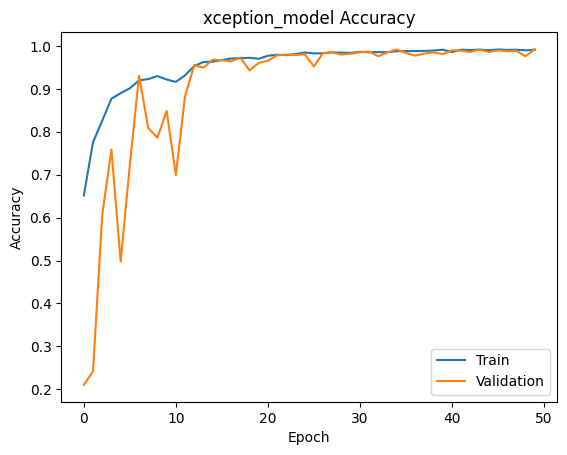

In [34]:
# Plot the training and validation accuracy over epochs
plt.plot(history_xception_model.history['accuracy'])
plt.plot(history_xception_model.history['val_accuracy'])
plt.title('xception_model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

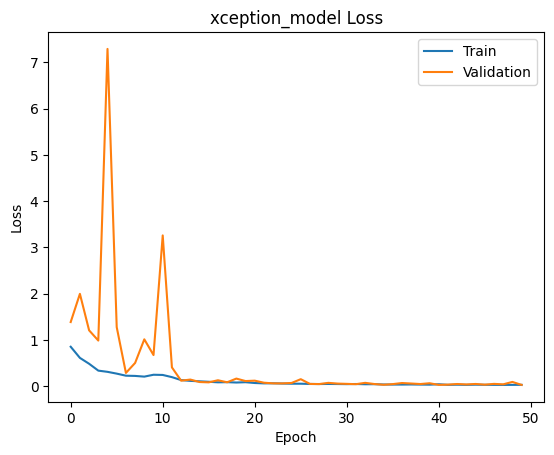

In [35]:
# Plot the training and validation loss over epochs
plt.plot(history_xception_model.history['loss'])
plt.plot(history_xception_model.history['val_loss'])
plt.title('xception_model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [36]:
# Evaluate the model
loss_xception_model, accuracy_xception_model = xception_model.evaluate(test_set, steps=test_set.samples // batch_size)
# loss, accuracy = model.evaluate(test_set, steps=32)

print("xception_model Test Loss:", loss_xception_model)
print("xception_model Test Accuracy:", accuracy_xception_model)

40/40 [==============================] - 3s 73ms/step - loss: 0.0256 - accuracy: 0.9930
xception_model Test Loss: 0.025643739849328995
xception_model Test Accuracy: 0.992968738079071


41/41 [==============================] - 3s 73ms/step
[0 0 0 ... 3 3 3]


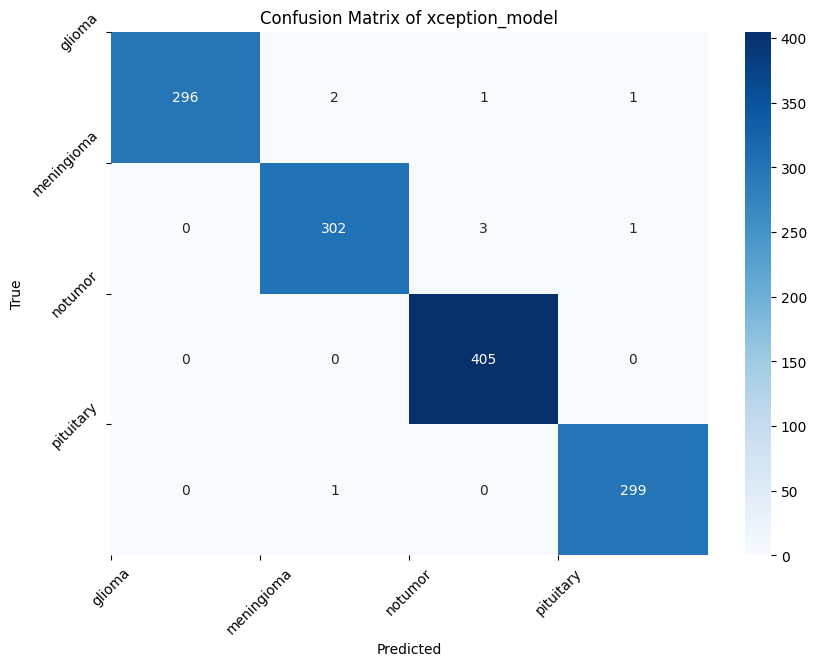

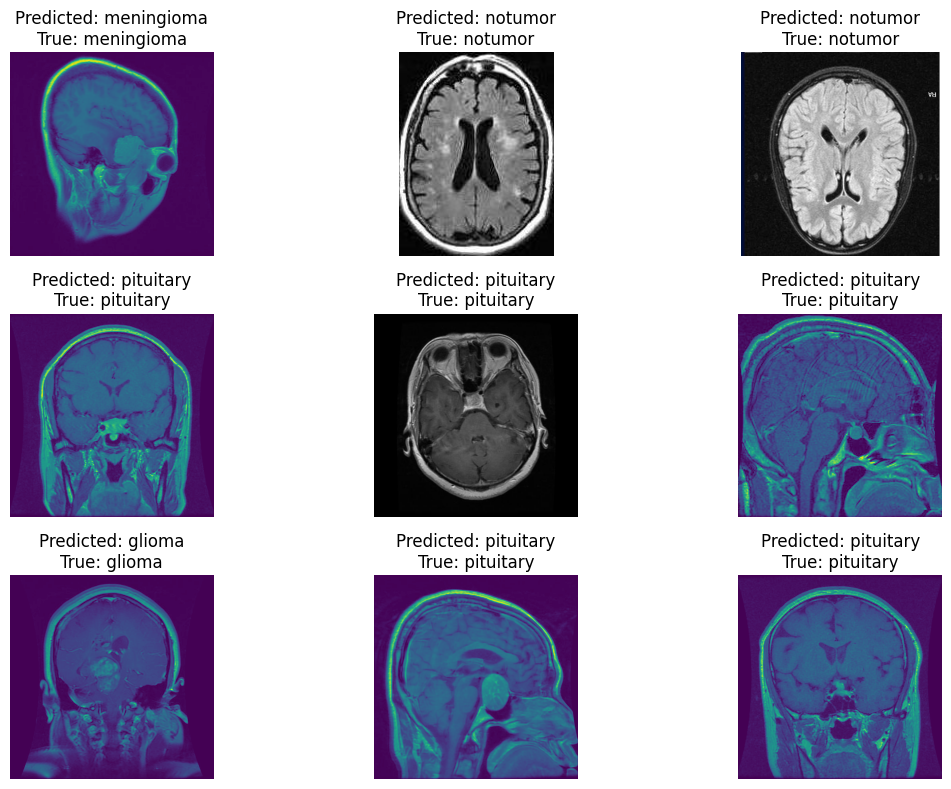

In [37]:
# Make predictions on the test dataset
predictions_xception_model = xception_model.predict(test_set)
predicted_categories_xception_model = np.argmax(predictions_xception_model, axis=1)

true_categories_xception_model = test_set.classes
print(true_categories_xception_model)

# Create a confusion matrix
confusion_matrix_xception_model = tf.math.confusion_matrix(true_categories_xception_model, predicted_categories_xception_model)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_xception_model, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of xception_model")
plt.tight_layout() #########
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_set.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
# print(sample_indices)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions_xception_model = [categories[predicted_categories_xception_model[i]] for i in sample_indices]
sample_true_labels_xception_model = [categories[true_categories_xception_model[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions_xception_model[i]}\nTrue: {sample_true_labels_xception_model[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Class: glioma
Precision: 1.0
Recall: 0.9866666666666667
F1-Score: 0.9932885906040269

Class: meningioma
Precision: 0.9901639344262295
Recall: 0.9869281045751634
F1-Score: 0.9885433715220949

Class: notumor
Precision: 0.9902200488997555
Recall: 1.0
F1-Score: 0.995085995085995

Class: pituitary
Precision: 0.9933554817275747
Recall: 0.9966666666666667
F1-Score: 0.995008319467554



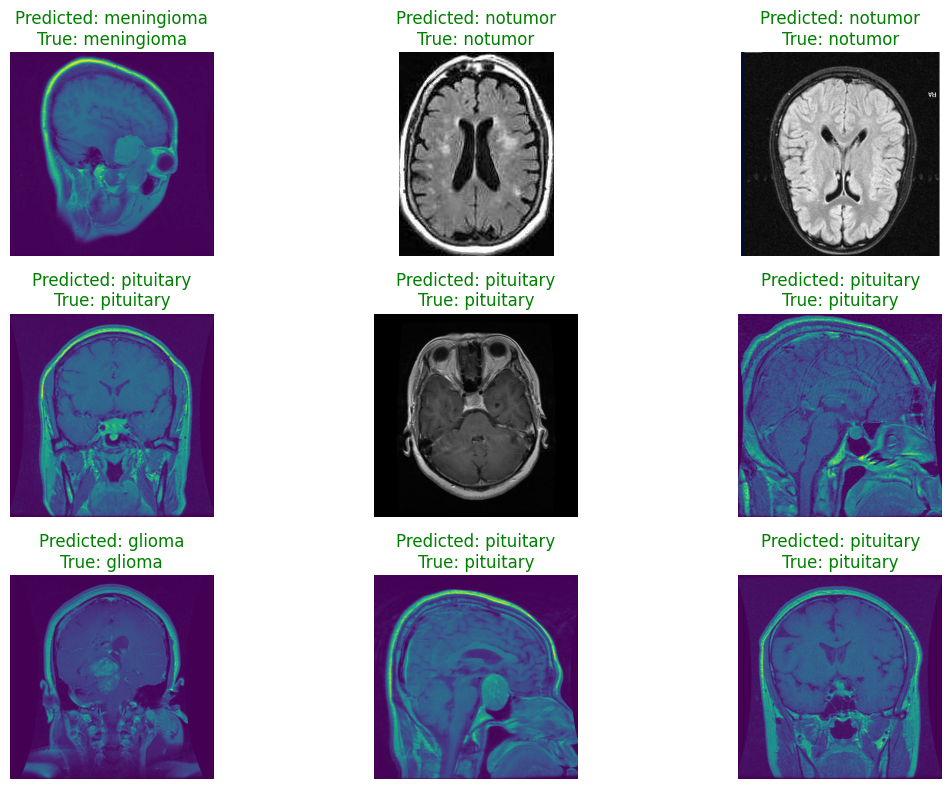

In [38]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision_xception_model = np.diag(confusion_matrix_xception_model) / np.sum(confusion_matrix_xception_model, axis=0)
recall_xception_model = np.diag(confusion_matrix_xception_model) / np.sum(confusion_matrix_xception_model, axis=1)
f1_score_xception_model = 2 * (precision_xception_model * recall_xception_model) / (precision_xception_model + recall_xception_model)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision_xception_model[i]}")
    print(f"Recall: {recall_xception_model[i]}")
    print(f"F1-Score: {f1_score_xception_model[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions_xception_model[i] == sample_true_labels_xception_model[i]:
        plt.title(f"Predicted: {sample_predictions_xception_model[i]}\nTrue: {sample_true_labels_xception_model[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions_xception_model[i]}\nTrue: {sample_true_labels_xception_model[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

4


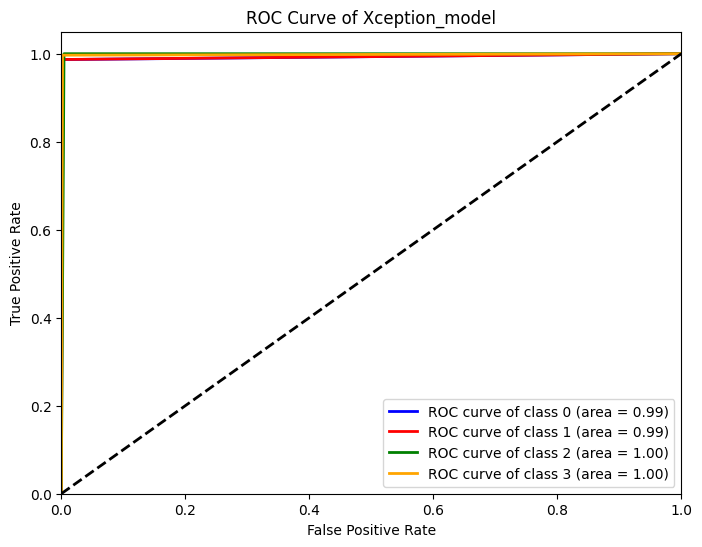

In [39]:
from sklearn.metrics import roc_curve, auc
from keras.models import load_model
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes = glob('/kaggle/input/brain-tumor-mri-dataset/Training/*')
num_classes = len(classes)
print(num_classes)

Y_test_bin = label_binarize(true_categories_xception_model, classes=np.arange(4))
Y_pred_bin = label_binarize(predicted_categories_xception_model, classes=np.arange(4))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']  # Add more colors if you have more classes

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Xception_model')
plt.legend(loc="lower right")

plt.show()

In [40]:
# Save the trained model
xception_model.save("Xception_model_brain_tumor_detection_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
# history = model.fit_generator(
history_InceptionV3_model = InceptionV3_model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    steps_per_epoch=train_set.samples // batch_size,
    validation_steps=test_set.samples // batch_size,
    callbacks=InceptionV3_callbacks
)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50
178/178 [==============================] - ETA: 0s - loss: 0.2015 - accuracy: 0.9261
Epoch 1: val_accuracy did not improve from 0.91250
178/178 [==============================] - 47s 266ms/step - loss: 0.2015 - accuracy: 0.9261 - val_loss: 0.2774 - val_accuracy: 0.8930 - lr: 2.0000e-04
Epoch 2/50
178/178 [==============================] - ETA: 0s - loss: 0.1997 - accuracy: 0.9204
Epoch 2: val_accuracy did not improve from 0.91250
178/178 [==============================] - 47s 266ms/step - loss: 0.1997 - accuracy: 0.9204 - val_loss: 0.2448 - val_accuracy: 0.9000 - lr: 2.0000e-04
Epoch 3/50
178/178 [==============================] - ETA: 0s - loss: 0.1996 - accuracy: 0.9278
Epoch 3: val_accuracy did not improve from 0.91250
178/178 [==============================] - 47s 266ms/step - loss: 0.1996 - accuracy: 0.9278 - val_loss: 0.2455 - val_accuracy: 0.8984 - lr: 2.0000e-04
Epoch 4/50
178/178 [==============================] - ETA: 0s - loss: 0.1878 - accuracy: 0.9312
Epoch 4: v

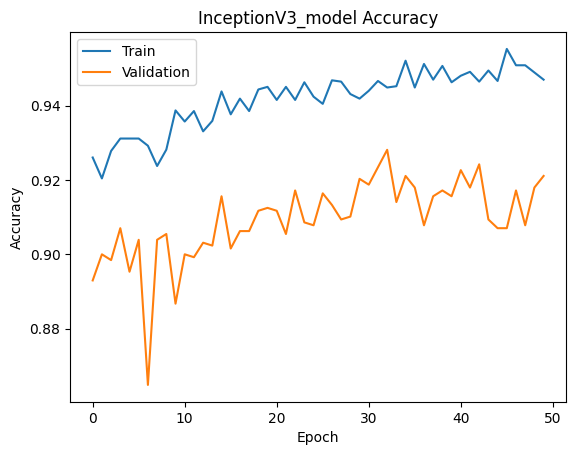

In [47]:
# Plot the training and validation accuracy over epochs
plt.plot(history_InceptionV3_model.history['accuracy'])
plt.plot(history_InceptionV3_model.history['val_accuracy'])
plt.title('InceptionV3_model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

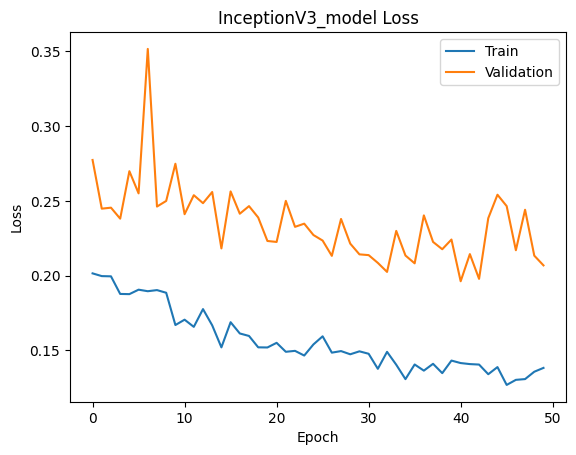

In [43]:
# Plot the training and validation loss over epochs
plt.plot(history_InceptionV3_model.history['loss'])
plt.plot(history_InceptionV3_model.history['val_loss'])
plt.title('InceptionV3_model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [44]:
# Evaluate the model
loss_InceptionV3_model, accuracy_InceptionV3_model = InceptionV3_model.evaluate(test_set, steps=test_set.samples // batch_size)
# loss, accuracy = model.evaluate(test_set, steps=32)

print("InceptionV3_model Test Loss:", loss_InceptionV3_model)
print("InceptionV3_model Test Accuracy:", accuracy_InceptionV3_model)

40/40 [==============================] - 3s 73ms/step - loss: 0.2069 - accuracy: 0.9211
InceptionV3_model Test Loss: 0.20689260959625244
InceptionV3_model Test Accuracy: 0.921093761920929


41/41 [==============================] - 7s 135ms/step
[0 0 0 ... 3 3 3]


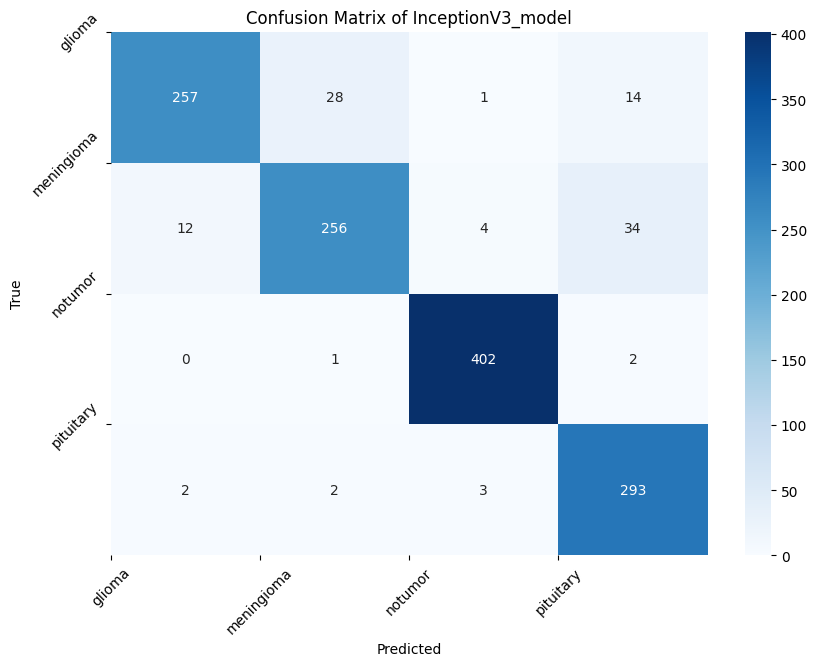

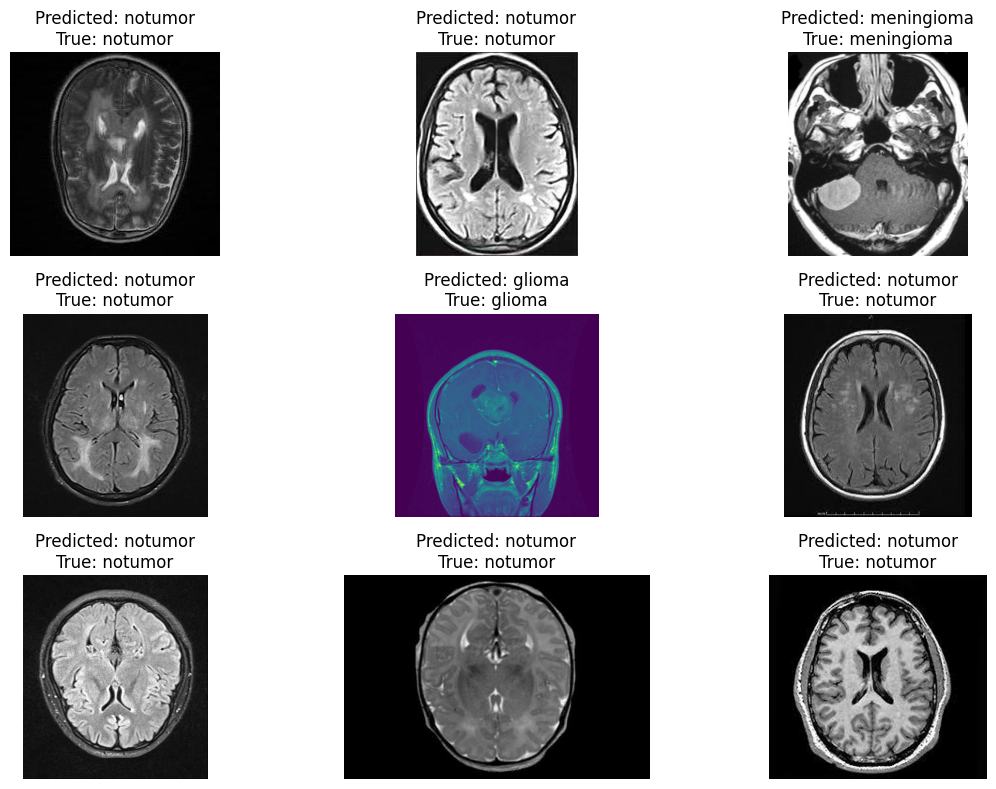

In [45]:
# Make predictions on the test dataset
predictions_InceptionV3_model = InceptionV3_model.predict(test_set)
predicted_categories_InceptionV3_model = np.argmax(predictions_InceptionV3_model, axis=1)

true_categories_InceptionV3_model = test_set.classes
print(true_categories_InceptionV3_model)

# Create a confusion matrix
confusion_matrix_InceptionV3_model = tf.math.confusion_matrix(true_categories_InceptionV3_model, predicted_categories_InceptionV3_model)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_InceptionV3_model, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of InceptionV3_model")
plt.tight_layout() #########
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_set.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
# print(sample_indices)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions_InceptionV3_model = [categories[predicted_categories_InceptionV3_model[i]] for i in sample_indices]
sample_true_labels_InceptionV3_model = [categories[true_categories_InceptionV3_model[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions_InceptionV3_model[i]}\nTrue: {sample_true_labels_InceptionV3_model[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Class: glioma
Precision: 0.948339483394834
Recall: 0.8566666666666667
F1-Score: 0.9001751313485115

Class: meningioma
Precision: 0.89198606271777
Recall: 0.8366013071895425
F1-Score: 0.8634064080944351

Class: notumor
Precision: 0.9804878048780488
Recall: 0.9925925925925926
F1-Score: 0.9865030674846627

Class: pituitary
Precision: 0.8542274052478134
Recall: 0.9766666666666667
F1-Score: 0.911353032659409



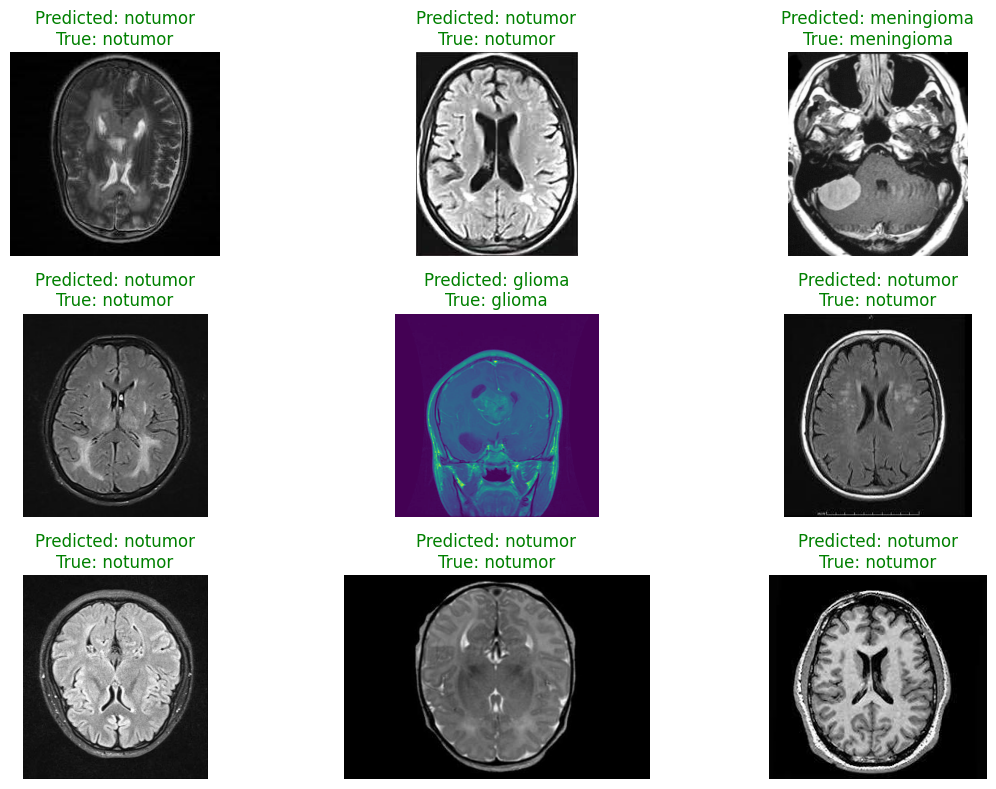

In [46]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision_InceptionV3_model = np.diag(confusion_matrix_InceptionV3_model) / np.sum(confusion_matrix_InceptionV3_model, axis=0)
recall_InceptionV3_model = np.diag(confusion_matrix_InceptionV3_model) / np.sum(confusion_matrix_InceptionV3_model, axis=1)
f1_score_InceptionV3_model = 2 * (precision_InceptionV3_model * recall_InceptionV3_model) / (precision_InceptionV3_model + recall_InceptionV3_model)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision_InceptionV3_model[i]}")
    print(f"Recall: {recall_InceptionV3_model[i]}")
    print(f"F1-Score: {f1_score_InceptionV3_model[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions_InceptionV3_model[i] == sample_true_labels_InceptionV3_model[i]:
        plt.title(f"Predicted: {sample_predictions_InceptionV3_model[i]}\nTrue: {sample_true_labels_InceptionV3_model[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions_InceptionV3_model[i]}\nTrue: {sample_true_labels_InceptionV3_model[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

4


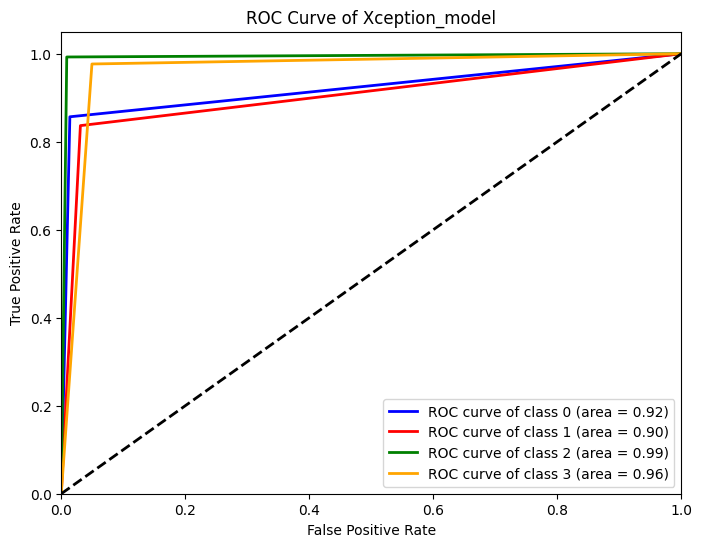

In [48]:
from sklearn.metrics import roc_curve, auc
from keras.models import load_model
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes = glob('/kaggle/input/brain-tumor-mri-dataset/Training/*')
num_classes = len(classes)
print(num_classes)

Y_test_bin = label_binarize(true_categories_InceptionV3_model, classes=np.arange(4))
Y_pred_bin = label_binarize(predicted_categories_InceptionV3_model, classes=np.arange(4))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']  # Add more colors if you have more classes

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Xception_model')
plt.legend(loc="lower right")

plt.show()

In [49]:
# Save the trained model
InceptionV3_model.save("InceptionV3_model_brain_tumor_detection_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
from tensorflow.keras.models import load_model

xception_model = load_model('/kaggle/working/Xception_model_brain_tumor_detection_model.h5')
xception_model = Model(inputs=xception_model.inputs,
                       outputs=xception_model.outputs,
                       name='xception_model')

InceptionV3_model = load_model('/kaggle/working/InceptionV3_model_brain_tumor_detection_model.h5')
InceptionV3_model = Model(inputs=InceptionV3_model.inputs,
                       outputs=InceptionV3_model.outputs,
                       name='InceptionV3_model')

In [8]:
models = [xception_model, InceptionV3_model]
model_input = Input(shape = (150, 150, 3))
model_outputs = [model(model_input) for model in models]
Ensamble_output = Average()(model_outputs)
Ensamble_model = Model(inputs=model_input, outputs=Ensamble_output, name='Ensamble_model')

In [15]:
# Define callbacks
Ensamble_check = ModelCheckpoint(filepath='Ensemble_checkpoint.h5', 
                                       monitor='val_accuracy', 
                                       verbose=1, 
                                       save_best_only=True, 
                                       mode='max')

Ensamble_callback = [Ensamble_check, reduce_lr]

start = datetime.now()

In [16]:
Ensamble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Train the model
history_Ensamble_model = Ensamble_model.fit(
    train_set,
    steps_per_epoch=train_set.samples // batch_size,
    epochs=epochs,
    validation_data=test_set,
    validation_steps=test_set.samples // batch_size,
    callbacks = Ensamble_callback
)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50


I0000 00:00:1710221539.173639     133 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


178/178 [==============================] - ETA: 0s - loss: 0.1720 - accuracy: 0.9488
Epoch 1: val_accuracy improved from -inf to 0.89609, saving model to Ensemble_checkpoint.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


178/178 [==============================] - 123s 456ms/step - loss: 0.1720 - accuracy: 0.9488 - val_loss: 0.2957 - val_accuracy: 0.8961 - lr: 0.0010
Epoch 2/50
178/178 [==============================] - ETA: 0s - loss: 0.1616 - accuracy: 0.9549
Epoch 2: val_accuracy improved from 0.89609 to 0.90781, saving model to Ensemble_checkpoint.h5
178/178 [==============================] - 53s 295ms/step - loss: 0.1616 - accuracy: 0.9549 - val_loss: 0.3614 - val_accuracy: 0.9078 - lr: 0.0010
Epoch 3/50
178/178 [==============================] - ETA: 0s - loss: 0.1910 - accuracy: 0.9442
Epoch 3: val_accuracy improved from 0.90781 to 0.91562, saving model to Ensemble_checkpoint.h5
178/178 [==============================] - 53s 294ms/step - loss: 0.1910 - accuracy: 0.9442 - val_loss: 0.2989 - val_accuracy: 0.9156 - lr: 0.0010
Epoch 4/50
178/178 [==============================] - ETA: 0s - loss: 0.1717 - accuracy: 0.9493
Epoch 4: val_accuracy improved from 0.91562 to 0.92734, saving model to Ensemble

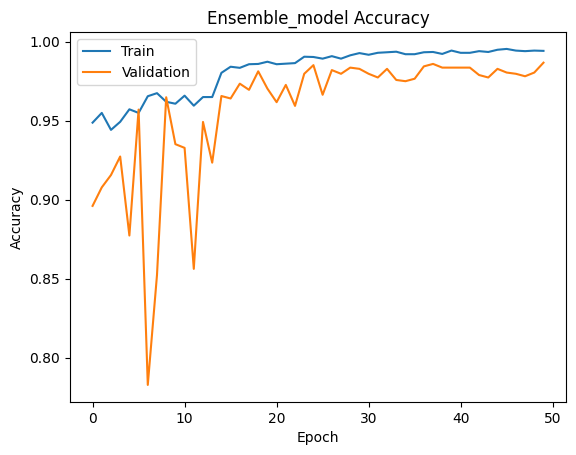

In [18]:
# Plot the training and validation accuracy over epochs
plt.plot(history_Ensamble_model.history['accuracy'])
plt.plot(history_Ensamble_model.history['val_accuracy'])
plt.title('Ensemble_model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# axes = plt.axes()
# axes.set_ylim([0.9, 1])
plt.legend(['Train', 'Validation'])
plt.show()

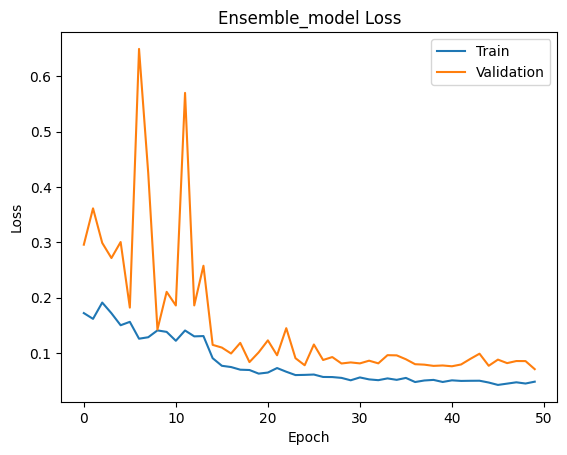

In [28]:
# Plot the training and validation loss over epochs
# plt.plot(history_Ensamble_model.history['loss'], color='red')
plt.plot(history_Ensamble_model.history['loss'])
plt.plot(history_Ensamble_model.history['val_loss'])
plt.title('Ensemble_model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [20]:
# Evaluate the model
loss_Ensamble_model, accuracy_Ensamble_model = Ensamble_model.evaluate(test_set, steps=test_set.samples // batch_size)
# loss, accuracy = model.evaluate(test_set, steps=32)

print("Ensemble_model Test Loss:", loss_Ensamble_model)
print("Ensemble_model Test Accuracy:", accuracy_Ensamble_model)

40/40 [==============================] - 4s 93ms/step - loss: 0.0706 - accuracy: 0.9867
Ensemble_model Test Loss: 0.07059161365032196
Ensemble_model Test Accuracy: 0.9867187738418579


41/41 [==============================] - 10s 197ms/step
[0 0 0 ... 3 3 3]


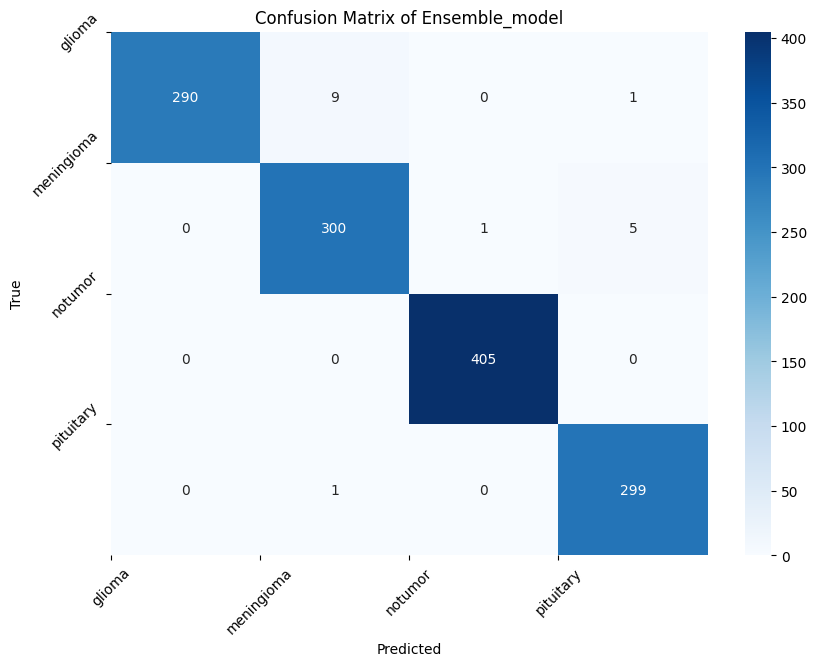

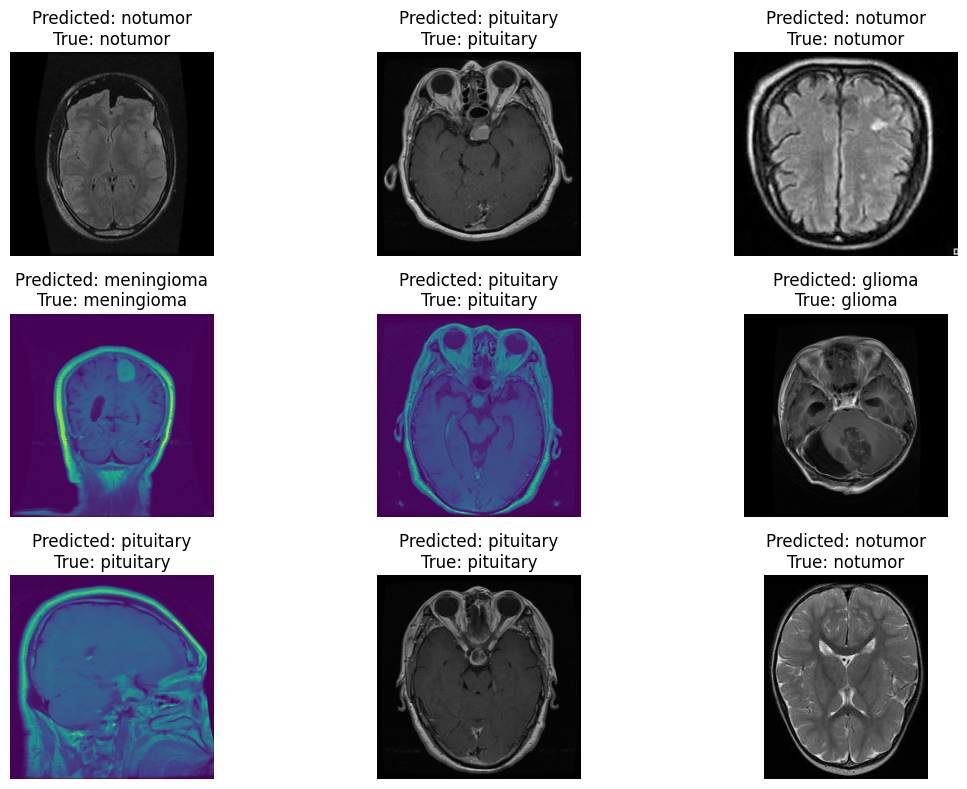

In [21]:
# Make predictions on the test dataset
predictions_Ensamble_model = Ensamble_model.predict(test_set)
predicted_categories_Ensamble_model = np.argmax(predictions_Ensamble_model, axis=1)

true_categories_Ensamble_model = test_set.classes
print(true_categories_Ensamble_model)

# Create a confusion matrix
confusion_matrix_Ensamble_model = tf.math.confusion_matrix(true_categories_Ensamble_model, predicted_categories_Ensamble_model)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_Ensamble_model, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of Ensemble_model")
plt.tight_layout() #########
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_set.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
# print(sample_indices)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions_Ensamble_model = [categories[predicted_categories_Ensamble_model[i]] for i in sample_indices]
sample_true_labels_Ensamble_model = [categories[true_categories_Ensamble_model[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions_Ensamble_model[i]}\nTrue: {sample_true_labels_Ensamble_model[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Class: glioma
Precision: 1.0
Recall: 0.9666666666666667
F1-Score: 0.983050847457627

Class: meningioma
Precision: 0.967741935483871
Recall: 0.9803921568627451
F1-Score: 0.9740259740259739

Class: notumor
Precision: 0.9975369458128078
Recall: 1.0
F1-Score: 0.9987669543773119

Class: pituitary
Precision: 0.980327868852459
Recall: 0.9966666666666667
F1-Score: 0.9884297520661156



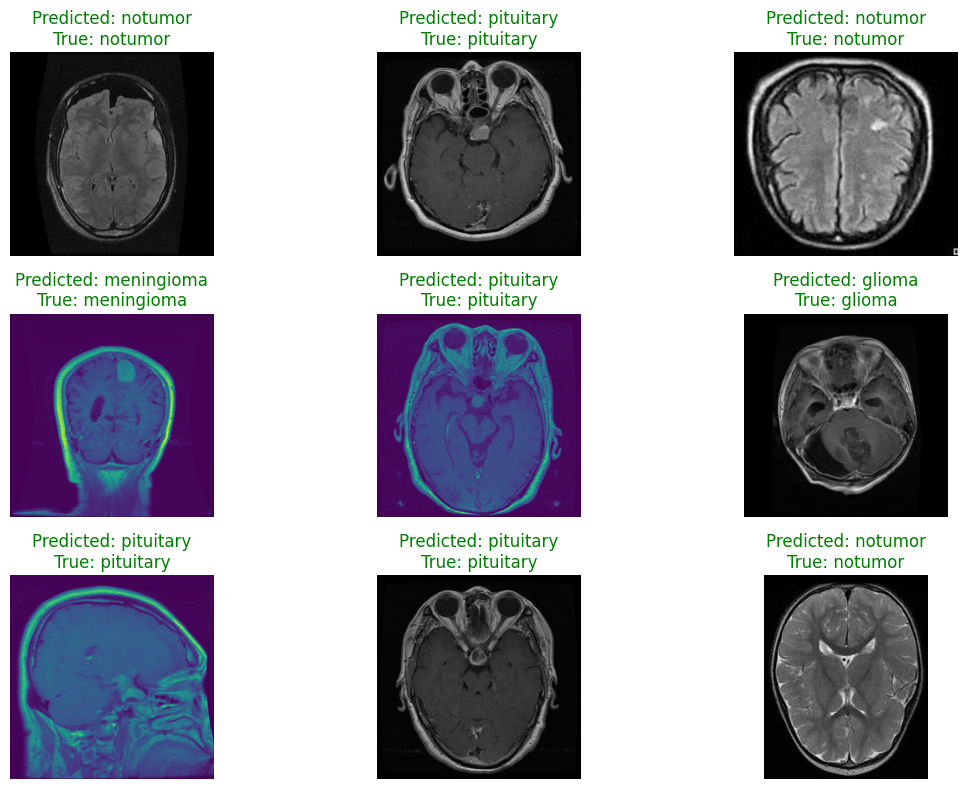

In [22]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision_Ensamble_model = np.diag(confusion_matrix_Ensamble_model) / np.sum(confusion_matrix_Ensamble_model, axis=0)
recall_Ensamble_model = np.diag(confusion_matrix_Ensamble_model) / np.sum(confusion_matrix_Ensamble_model, axis=1)
f1_score_Ensamble_model = 2 * (precision_Ensamble_model * recall_Ensamble_model) / (precision_Ensamble_model + recall_Ensamble_model)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision_Ensamble_model[i]}")
    print(f"Recall: {recall_Ensamble_model[i]}")
    print(f"F1-Score: {f1_score_Ensamble_model[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions_Ensamble_model[i] == sample_true_labels_Ensamble_model[i]:
        plt.title(f"Predicted: {sample_predictions_Ensamble_model[i]}\nTrue: {sample_true_labels_Ensamble_model[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions_Ensamble_model[i]}\nTrue: {sample_true_labels_Ensamble_model[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

4


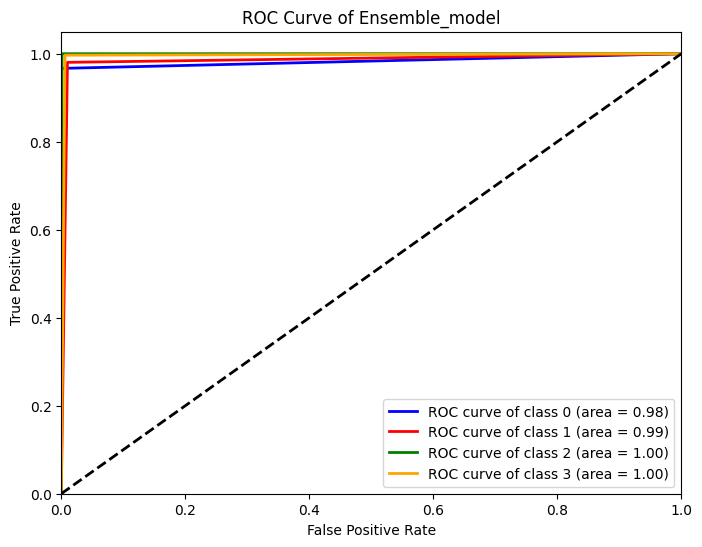

In [23]:
from sklearn.metrics import roc_curve, auc
from keras.models import load_model
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes = glob('/kaggle/input/brain-tumor-mri-dataset/Training/*')
num_classes = len(classes)
print(num_classes)

Y_test_bin = label_binarize(true_categories_Ensamble_model, classes=np.arange(4))
Y_pred_bin = label_binarize(predicted_categories_Ensamble_model, classes=np.arange(4))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']  # Add more colors if you have more classes

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Ensemble_model')
plt.legend(loc="lower right")

plt.show()

In [29]:
# Save the trained model
Ensamble_model.save("Ensemble_model_brain_tumor_detection_model.h5")